In [2]:
import numpy as np
import pysal
# import pysal.explore as pysal
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib import colors
from netCDF4 import Dataset
# import pandas as pd
import properscoring as ps
import warnings
# import xarray as xr
# from matplotlib import cm
# import pysteps.verification.spatialscores as spatialscores
from scipy import stats
from utils.evaluation import plot_predictions,plot_anomaly,plot_histogram,calc_peak,calc_mean,segment_image,segment_diff
from utils.metrics import calculate_crps
# from utils.metrics import calculate_fid
# import xesmf as xe - not working now
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

(16860, 100, 100, 4)
show


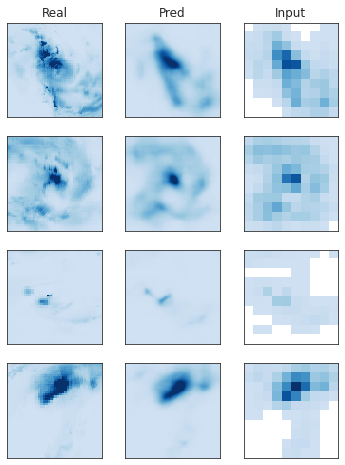

In [6]:
model = '_cat1_storms'
model = '_TS'
# set mode
mode = 'validation'


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]
pred_ensemble = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# train_X = np.load('/user/work/al18709/tc_data_mswep/train_X.npy')
# train_y = np.load('/user/work/al18709/tc_data_mswep/train_y.npy')

print(pred_ensemble.shape)
# real_train = np.load('/user/home/al18709/work/cgan_predictions/train_real.npy')[0][:,:,:,0]
# pred_train = np.load('/user/home/al18709/work/cgan_predictions/train_pred.npy')[0][:,:,:,0]
# inputs_train = np.load('/user/home/al18709/work/cgan_predictions/train_input.npy')[0][:,:,:,0]
plot_predictions(real,pred,inputs,plot='show')
# print(np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode)).shape)
# pred1 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,1]
# plot_predictions(real,pred1,inputs,plot='show')
# pred2 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,2]
# plot_predictions(real,pred2,inputs,plot='show')
# pred3 = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,3]
# plot_predictions(real,pred3,inputs,plot='show')

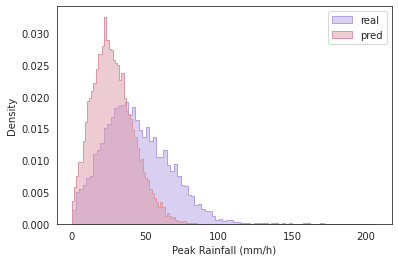

KstestResult(statistic=0.32793594306049817, pvalue=0.0)
KstestResult(statistic=0.32793594306049817, pvalue=0.0)


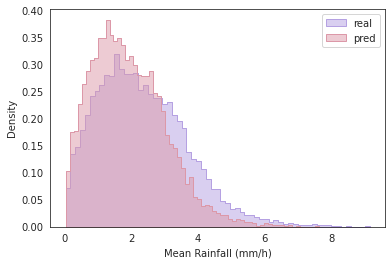

KstestResult(statistic=0.13825622775800717, pvalue=5.028671816455203e-141)
KstestResult(statistic=0.0, pvalue=1.0)


In [8]:
# metric 1
# A standard metric to check how the distributions compare
# TODO: integrate ensemble predictions
# distributions
peak_reals = calc_peak(real)
peak_preds = calc_peak(pred)
plot_histogram(peak_reals,peak_preds,5,0.5,type = 'Peak')
ks = stats.kstest(peak_reals, peak_preds)
print(ks)
ks = stats.ks_2samp(peak_reals, peak_preds)
print(ks)

mean_reals = calc_mean(real)
mean_preds = calc_mean(pred)
plot_histogram(mean_reals,mean_preds,5,0.5)
ks = stats.kstest(mean_reals, mean_preds)
print(ks)
ks = stats.kstest(mean_preds,mean_preds)
print(ks)

# ks null hypothesis: two samples drawn from populations with the same distributions
# if p-value is small then you can reject the null hypothesis
# I think we want the p value to be large? or close to 1?

# TODO: could do the same thing for the 90th percentile or just the extreme validation set

In [9]:
# metric 2 
# common probabilistic forecasting score
# CRPS
crps = calculate_crps(real,pred_ensemble)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

crps = ps.crps_ensemble(real,pred_ensemble)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

(16860, 100, 100)
[0.81740904 0.55800515 0.5188102  ... 0.3260961  0.8303369  0.8413955 ]
0.79511696
(16860, 100, 100)
[0.81740899 0.55800514 0.51881023 ... 0.32609608 0.83033691 0.84139549]
0.795114613433686


In [10]:
# metric 3
# standard sanity check, though not usually for stochastic models
# RMSE
nimages,_,_ = real.shape
RMSE = []
for i in range(nimages):
	rmse = sqrt(mean_squared_error(real[i], pred[i]))
	RMSE.append(rmse)

print(np.mean(RMSE))

1.822069576172915


In [18]:
# metric 4
# metric to look specifically at spatial structure
# https://gis.stackexchange.com/questions/273785/morans-i-on-2d-arrays-rasters
# Spatial Correlation
# Moran's I - positive, negative autocorrelation - positive means similar values are clustered together and negative mean there's no spatial pattern
# https://journals.ametsoc.org/view/journals/mwre/136/6/2007mwr2255.1.xml
# https://d1wqtxts1xzle7.cloudfront.net/49336481/Probabilistic_rainfall_thresholds_for_fl20161004-25957-1lpf9s8-with-cover-page-v2.pdf?Expires=1646313112&Signature=A~uO2wqiCKdkqPu~QolyURBkRguxzw9P84Yfw8PrWYRkrOXMDyxAaxQmJafqcQOtr1FR68gWjq3MaLa2KFV3OwSvhB8douIzF4TJDXSPChkdwAh7p-Yc5A5WNPCFTMZkGJ-DyP60hZObnZUKs7y45FUcM9sWIbLfMgIuZXrW7vzf8vIXeQi-44LzV98XKYItKe7DAaTxyEWHGmWdFmlwKmBi~88P6rxAZd5xvNIsb4qzWNY~go-fKV~5oTcPQcF2VcsINGMjOkeywMxJQSm0cwHKpmS-ikhiXkBa5BrqsbwRQLNcJnbsWj-berQFW111h2ODWsAIAGp1AcF8qyuTdg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA


w = pysal.lat2W(real[0].shape[0],real[0].shape[1], rook=False, id_type="int")
mir = pysal.Moran(real[0], w, permutations = 9999)
lm = pysal.Moran_Local(real[0],w)
moran_significance = np.reshape(lm.p_sim, real[0].shape)
print(mir.I)
w = pysal.lat2W(pred[0].shape[0],pred[0].shape[1], rook=False, id_type="int")
mir = pysal.Moran(pred[0], w, permutations = 9999)
lm = pysal.Moran_Local(pred[0],w)
moran_significance = np.reshape(lm.p_sim, pred[0].shape)
print(mir.I)
# print(lm)
# print(moran_significance)

0.9173132041181403
0.9842604463430313


In [36]:
# metric 6
# Accumulated Rainfall

In [ ]:
# metric 7 
# Similarity Score